## **Free topic big data analysis project**




**Topic choosed : Job fakeness detection** (17880 records)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import time
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn import preprocessing, model_selection, pipeline
from sklearn.metrics import f1_score, roc_auc_score,roc_curve
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Importing data

In [2]:
df= pd.read_csv('/content/fake_job_postings.csv',engine='python')

### **1)- Data Cleaning and transformation**

In [3]:
df.tail()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0
17879,17880,Web Application Developers,"NZ, N, Wellington",Engineering,NaN,Vend is looking for some awesome new talent to...,Who are we?Vend is an award winning web based ...,We want to hear from you if:You have an in-dep...,NaN,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Engineering,0


**Data analysis**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [5]:
df.shape

(17880, 18)

Null values count

In [6]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

Filling missing values with empty in text columns

In [7]:
text_df = df[["title", "company_profile", "description", "requirements", "benefits","fraudulent"]]
text_df = text_df.fillna(' ')
text_df.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


Fill categorical columns with None

In [8]:
cat_df = df[["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education", "industry", "function","fraudulent"]]
cat_df = cat_df.fillna("None")

cat_df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,0,Other,Internship,None,None,Marketing,0
1,0,1,0,Full-time,Not Applicable,None,Marketing and Advertising,Customer Service,0
2,0,1,0,None,None,None,None,None,0
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


Fill na in original dataset df

In [9]:
df.fillna(" ",inplace = True)

### **2)- Feature engineering and analysis report**


Creating a column with all texts

In [10]:
df['text'] = df['title'] + ' ' + df['location'] + ' ' + df['department'] + ' ' + df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits'] + ' ' + df['employment_type'] + ' ' + df['required_education'] + ' ' + df['industry'] + ' ' + df['function'] 

In [11]:
df

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text
0,1,Marketing Intern,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0,"Marketing Intern US, NY, New York Marketing We..."
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0,"Customer Service - Cloud Video Production NZ, ..."
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,"Account Executive - Washington DC US, DC, Wash..."
4,5,Bill Review Manager,"US, FL, Fort Worth",,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,"Bill Review Manager US, FL, Fort Worth SpotS..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,,Computer Software,Sales,0,"Account Director - Distribution CA, ON, Toron..."
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,"Payroll Accountant US, PA, Philadelphia Accoun..."
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",,,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,0,0,0,Full-time,,,,,0,Project Cost Control Staff Engineer - Cost Con...
17878,17879,Graphic Designer,"NG, LA, Lagos",,,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0,"Graphic Designer NG, LA, Lagos Nemsia Stud..."


Creating a column with length of texts

In [12]:
df['text_length'] = df.text.apply(len)

Analysing dataset stability

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


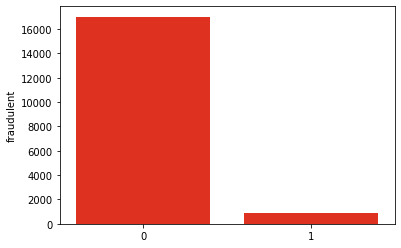

In [13]:
fraud = df["fraudulent"].value_counts()
sns.barplot(fraud.index, fraud, color="#FF1700")

In [14]:
df.fraudulent.value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

Real and fake posting and Text length relation

Text(0.5, 0, 'Text Length')

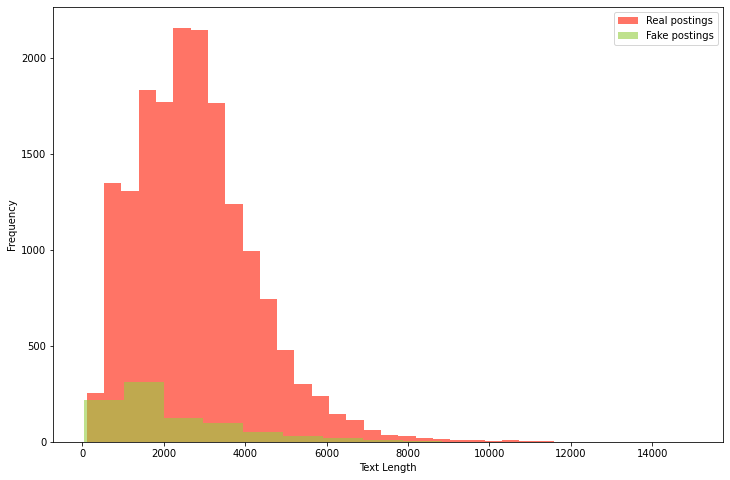

In [15]:
plt.figure(figsize=(12, 8))

df[df.fraudulent==0].text_length.plot(bins=35, kind='hist', color='#FF1700', 
                                       label='Real postings', alpha=0.6)
df[df.fraudulent==1].text_length.plot(kind='hist', color='#95CD41', 
                                       label='Fake postings', alpha=0.6)
plt.legend()
plt.xlabel("Text Length")

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


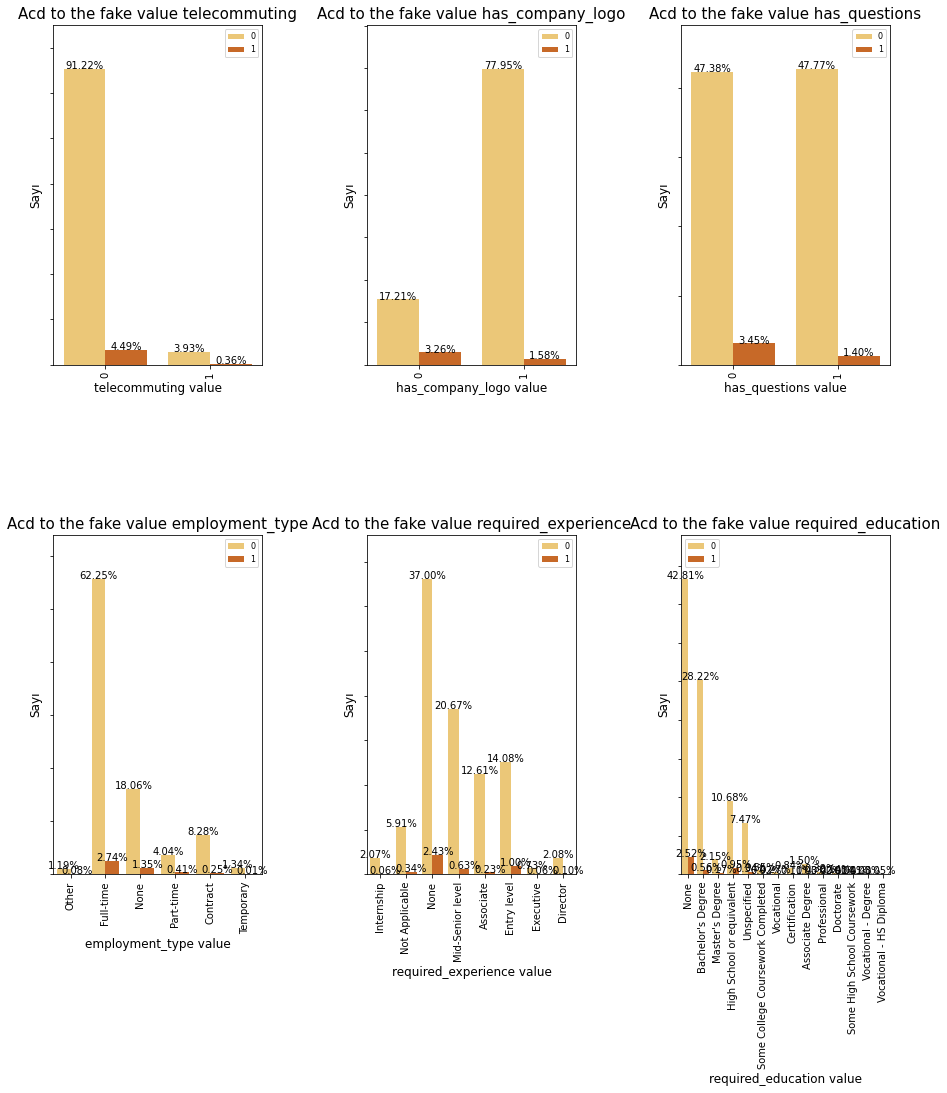

In [16]:
cat_cols = ["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education",]

import matplotlib.gridspec as gridspec 
grid = gridspec.GridSpec(3, 3, wspace=0.5, hspace=0.5) 
plt.figure(figsize=(15,25)) 


for n, col in enumerate(cat_df[cat_cols]): 
    ax = plt.subplot(grid[n]) 
    sns.countplot(x=col, data=cat_df, hue='fraudulent', palette='YlOrBr') 
    ax.set_ylabel('Say', fontsize=12) 
    ax.set_title(f'Acd to the fake value {col}', fontsize=15)
    ax.set_xlabel(f'{col} value', fontsize=12)
    xlabels = ax.get_xticklabels() 
    ylabels = ax.get_yticklabels() 
    ax.set_xticklabels(xlabels,  fontsize=10)
    ax.set_yticklabels(ylabels,  fontsize=10)
    plt.legend(fontsize=8)
    plt.xticks(rotation=90) 
    total = len(cat_df)
    sizes=[] 
    for p in ax.patches: 
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=10) 
    ax.set_ylim(0, max(sizes) * 1.15)


plt.show()

Real and fake posting and word count relation

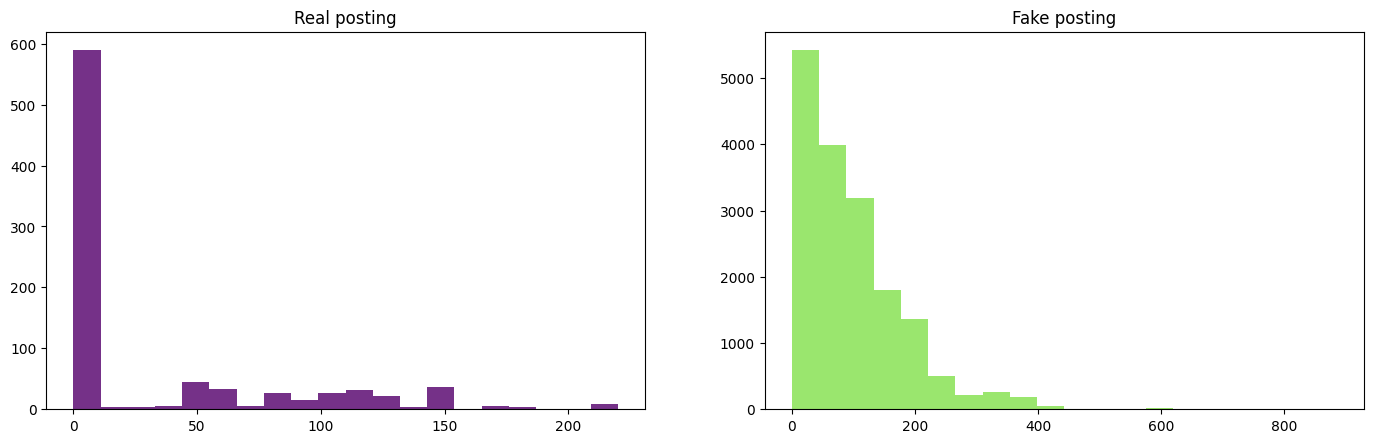

In [17]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=text_df[text_df["fraudulent"]==1]['company_profile'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='#753188')
ax1.set_title('Real posting')
num=text_df[text_df["fraudulent"]==0]['company_profile'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20,color='#9AE66E')
ax2.set_title('Fake posting')
plt.show()


Feature engineering on requirements column



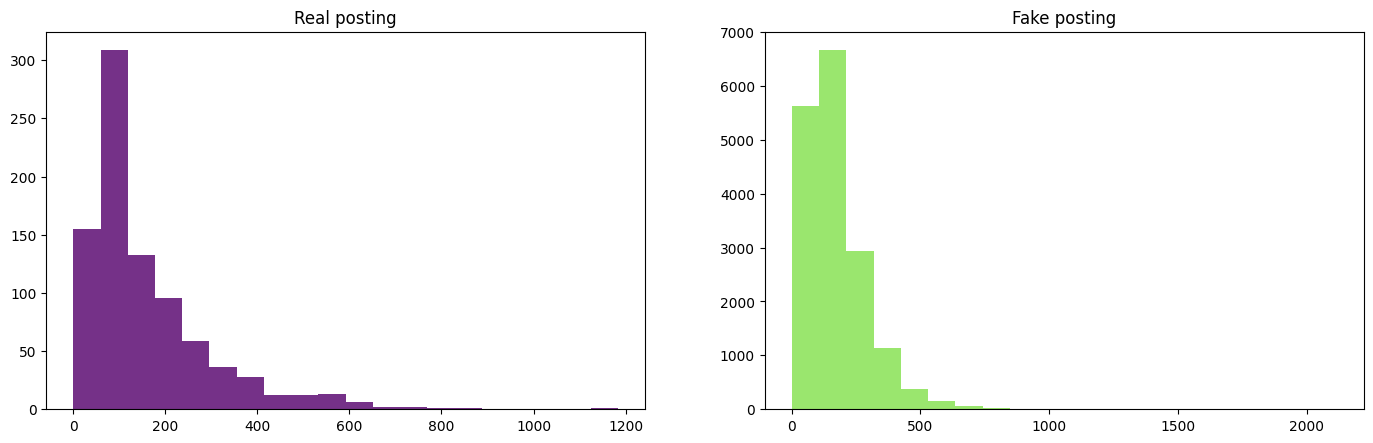

In [18]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=text_df[text_df["fraudulent"]==1]['description'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='#753188')
ax1.set_title('Real posting')
num=text_df[text_df["fraudulent"]==0]['description'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20,color='#9AE66E')
ax2.set_title('Fake posting')
plt.show()

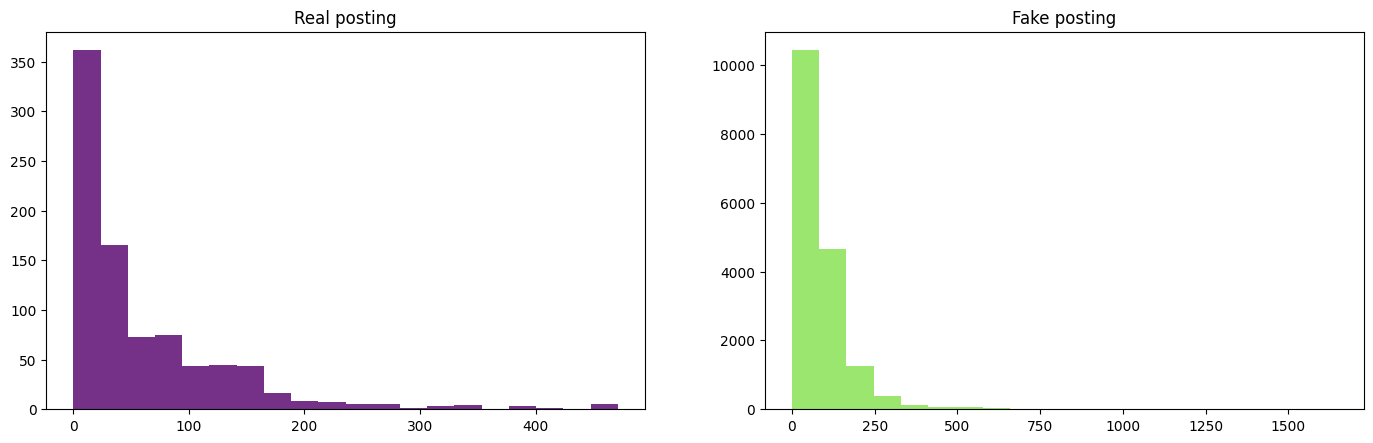

In [19]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=text_df[text_df["fraudulent"]==1]['requirements'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='#753188')
ax1.set_title('Real posting')
num=text_df[text_df["fraudulent"]==0]['requirements'].str.split().map(lambda x: len(x))
ax2.hist(num,bins = 20,color='#9AE66E')
ax2.set_title('Fake posting')
plt.show()

Benifits column

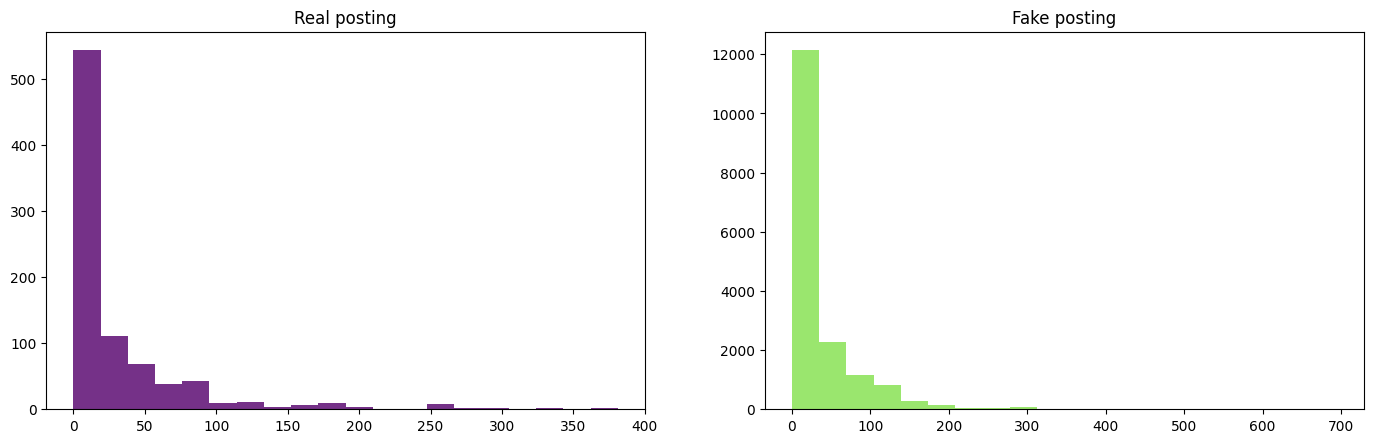

In [20]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=text_df[text_df["fraudulent"]==1]['benefits'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 20,color='#753188')
ax1.set_title('Real posting')
num=text_df[text_df["fraudulent"]==0]['benefits'].str.split().map(lambda x: len(x))
ax2.hist(num, bins = 20,color='#9AE66E')
ax2.set_title('Fake posting')
plt.show()

Cleanliness and Layout of Texts

In [21]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [23]:
lemmatizer = WordNetLemmatizer()
def text_cleaning(text):
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text if not word in stopwords.words('english')]
    return ' '.join(text)    

In [ ]:
df['text'] = df['text'].apply(text_cleaning)

WordCloud

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.fraudulent == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.fraudulent == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
df.info()

### **3)- Model selection and application**

In [ ]:
X = df.text
y = df.fraudulent

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state = 0)

TF-IDF

In [ ]:
tfid = TfidfVectorizer(min_df=0, max_df=1, ngram_range=(1,3))
tfid_train = tfid.fit_transform(X_train)
tfid_test = tfid.transform(X_test)
print('Tfidf_train : ', tfid_train.shape)
print('Tfidf_test : ', tfid_test.shape)

Naive Bayes

In [ ]:
mnb=MultinomialNB()
mnb_tfidf=mnb.fit(tfid_train, y_train)

In [ ]:
mnb_tfidf_predict=mnb.predict(tfid_test)

Confusion matrix

In [ ]:
mnb_bow_predict=mnb.predict(tfid_test)
cm_cv = confusion_matrix(y_test,mnb_bow_predict)

cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Real'
cm_cv.columns.name = 'Prediction'

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm_cv,cmap= "YlGn",annot = True, fmt='')

In [ ]:
mnb_tfidf_score=accuracy_score(y_test, mnb_tfidf_predict)
print("Accuracy Score (Accuracy rate) :", mnb_tfidf_score)

AUC: ROC Curve

In [ ]:
fpr, tpr, thr = roc_curve(y_test, mnb.predict_proba(tfid_test)[:,1])
auc = roc_auc_score(y_test, mnb_tfidf_predict)
lw = 2
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='#4C3F91', lw=lw, label="Curve Area = %0.3f" % auc)
plt.plot([0, 1], [0, 1], color='#9145B6', lw=lw, linestyle='dotted')
plt.xlabel('False Positive Rate')
plt.ylabel('Correct Positive Ratio')
plt.legend(loc="lower right")
plt.show()